In [102]:
#import cartopy.crs as ccrs
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib
from matplotlib import animation, rc, rcParams
#matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from matplotlib.path import Path
from pandas.plotting import table
import datetime as dt
import xarray as xr
#import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
from scipy import interpolate
from matplotlib.mlab import griddata
import datetime as dt
from datetime import timezone

con = sqlite3.connect('/home/ec2-user/test.db')
now = dt.datetime.now(timezone.utc).strftime('%Y-%m-%d %H:%M')


#def main():
#plt.clf()
stations_df = pd.read_sql('SELECT name, id, region_id, longitude, latitude from station', con)
#print (stations_df)
#data = pd.read_sql('SELECT tt.* FROM measurement tt INNER JOIN (SELECT station_id, MAX(time) AS MaxDateTime FROM measurement GROUP BY station_id) groupedtt ON tt.station_id = groupedtt.station_id AND tt.time = groupedtt.MaxDateTime', con)
data = pd.read_sql('SELECT time, CS, station_id, MUFD, cs from measurement', con)
data['time'] = pd.to_datetime(data.time)

#data.head(10)

#delete low confidence measurements
#df = df.drop(df[df.cs == 0].index)
data = data.drop(data[data.MUFD == 0].index)
data.dropna(subset=['MUFD'], inplace=True)

#get latest MUF for each station
data = data.groupby(['station_id']).tail(1)
#print (data)
df = stations_df.merge(data, left_on='id', right_on='station_id', how='inner')
print(df)

#get latest MUF for each station
#df = df.groupby(['station_id']).tail(1)

#filter out data older than 1hr
#age = (dt.datetime.now() - dt.timedelta(minutes=60)).strftime('%Y-%m-%d %H:%M')
#df = df.loc[df['time'] > age]
#df['time'] = pd.to_datetime(df.time)
#df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M')
df['MUFD'] = df['MUFD'].astype(float)

#df.ix[df.longitude > 180, 'longitude'] = df.longitude - 360
#df.sort_values(by=['longitude'], inplace=True)

#try from SO 
##cols_to_use = stations_df.columns.difference(df.columns)
##df = pd.merge(df, stations_df[cols_to_use], left_index=True, right_index=True, how='outer')
##df = df[['time','MUFD','latitude', 'longitude', 'name']]
#df.set_index(['latitude', 'longitude','time'], inplace=True)
#df.set_index(['time', 'station_id', 'name', 'region_id', 'latitude', 'longitude'], inplace=True)
#print (df)
#df.head (300)
#df.dropna(subset=['MUFD'], inplace=True)
#df.to_csv('df.csv')

                          name  id  region_id  longitude  latitude  \
0              Austin, TX, USA   1          4     262.30     30.40   
1              Roquetes, Spain   3          6       0.50     40.80   
2               Athens, Greece   4          6      23.50     38.00   
3      Millstone Hill, MA, USA   6          4     288.50     42.60   
4    Pruhonice, Czech Republic   7          6      14.60     50.00   
5           Juliusruh, Germany  10          6      13.40     54.60   
6             Boulder, CO, USA  11          4     254.70     40.00   
7             Dourbes, Belgium  12          6       4.60     50.10   
8            Boa Vista, Brazil  13          5     299.30      2.80   
9            Fortaleza, Brazil  15          5     321.60     -3.90   
10        I-Cheon, South Korea  16          2     127.54     37.14   
11          Jeju Island, Korea  17          2     126.30     33.43   
12              Moscow, Russia  19          2      37.30     55.47   
13              Alpe

In [103]:
# grid data
numcols, numrows = 100, 100
xi = np.linspace(df['longitude'].min(), df['longitude'].max(), numcols)
yi = np.linspace(df['latitude'].min(), df['latitude'].max(),numrows)
xi, yi = np.meshgrid(xi, yi)
# interpolate safe way with no extrapolation
x, y, z = df['longitude'].values, df['latitude'].values, df.MUFD.values
rbf = interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

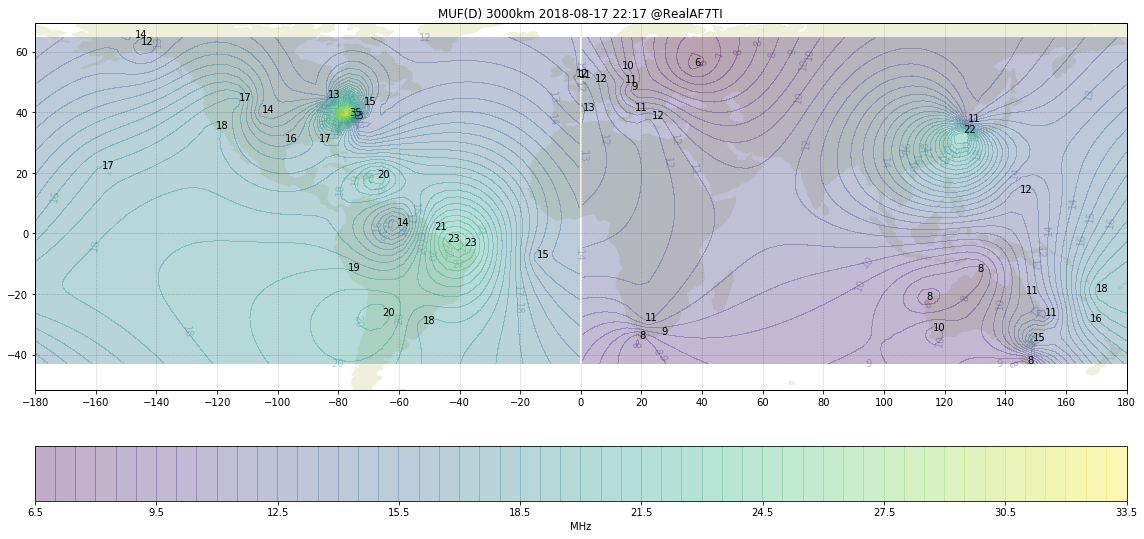

In [114]:
#plot data
#from cartopy.util import add_cyclic_point

fig = plt.figure(figsize=(16, 24))
ax = plt.axes(projection=ccrs.PlateCarree())

mycontour = plt.contourf(xi, yi, zi, 60,
            transform=ccrs.PlateCarree(),
            alpha=0.33)

#ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.set_global()



ax.grid(linewidth=.5, color='black', alpha=0.25, linestyle='--')
ax.set_xticks([-180, -160, -140, -120,-100, -80, -60,-40,-20, 0, 20, 40, 60,80,100, 120,140, 160,180], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60,-40,-20, 0, 20, 40, 60,80], crs=ccrs.PlateCarree())

#ax.set_extent([-147.07, 167.96, -51.6, 69.6], ccrs.PlateCarree())
ax.set_extent([-180, 180, -51.6, 69.6], ccrs.PlateCarree())

#labeldf = df
#labeldf.loc[labeldf.longitude > 180, 'longitude'] = labeldf.longitude - 360
for index, row in df.iterrows():
  lon = float(row['longitude'])
  lat = float(row['latitude'])
  #print (lon, ' ' , lat)
  ax.text(lon, lat, int(row['MUFD']), fontsize=10,ha='left', transform=ccrs.PlateCarree()) 
  #ax1.plot(lon, lat, row['MUFD'])
plt.clabel(mycontour, inline=0, fontsize=10, fmt='%.0f')

#CS2 = plt.contour(mycontour, levels=mycontour.levels[::8])

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(mycontour, fraction=0.5, orientation='horizontal', pad=0.033)
cbar.set_label('MHz')
plt.title("MUF(D) 3000km " + str(now) + ' @RealAF7TI')
# Add the contour line levels to the colorbar
#cbar.add_lines(CS2)

plt.tight_layout()
plt.show()

In [112]:
df

,name,id,region_id,longitude,latitude,time,cs,station_id,MUFD,cs
0,"Austin, TX, USA",1,4,262.30,30.40,2018-08-17 19:50:05,100,1,16.29,100
1,"Roquetes, Spain",3,6,0.50,40.80,2018-08-17 19:55:02,100,3,13.59,100
2,"Athens, Greece",4,6,23.50,38.00,2018-08-17 19:55:00,65,4,12.12,65
3,"Millstone Hill, MA, USA",6,4,288.50,42.60,2018-08-17 20:30:00,100,6,15.11,100
4,"Pruhonice, Czech Republic",7,6,14.60,50.00,2018-08-17 20:30:00,70,7,11.13,70
5,"Juliusruh, Germany",10,6,13.40,54.60,2018-08-17 20:18:16,45,10,10.35,45
6,"Boulder, CO, USA",11,4,254.70,40.00,2018-08-17 20:05:05,100,11,14.58,100
7,"Dourbes, Belgium",12,6,4.60,50.10,2018-08-17 20:20:02,80,12,12.75,80
8,"Boa Vista, Brazil",13,5,299.30,2.80,2018-07-29 23:50:00,35,13,14.53,35
9,"Fortaleza, Brazil",15,5,321.60,-3.90,2018-08-14 15:10:00,90,15,23.31,90
